# TUIA / AAII - TP1: Redes Densas y Convoluciones - Problema 2

> *Modelo de Clasificación para predecir si el paciente tiene diabetes o no.*


# Procedimientos Previos

## Preparación del entorno

### Librerías

In [1]:
# Datasets
import gdown
import zipfile

# Data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Visualizaciones
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from plotly.subplots import make_subplots
import plotly.graph_objs as go
import seaborn as sns

# ML metrics
from sklearn.metrics import mean_squared_error, r2_score, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, auc

# Redes Neuronales
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Dense, Input, Dropout

In [2]:
# Importar desde Google Drive
!pip install -q gdown

### GPU

In [3]:
# Configurar para que TensorFlow utilice la GPU por defecto
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Configurar para que TensorFlow asigne memoria dinámicamente
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        # Especificar la GPU por defecto
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Manejar error
        print(e)

## Dataset

El dataset proporcionado incluye las siguientes variables para cada paciente:
* **Embarazos**: Número de veces embarazada
* **Glucosa**: Concentración de glucosa en plasma a las 2 horas en una prueba de tolerancia oral a la glucosa
* **Presión arterial**: Presión arterial diastólica (mm Hg)
* **Espesor de la piel**: Espesor del pliegue cutáneo del tríceps (mm)
* **Insulina**: Insulina sérica a las 2 horas (mu U/ml)
* **IMC**: Índice de masa corporal (peso en kg/(altura en m)^2)
* **Función de pedigree de la diabetes**: Valor que evalúa la probabilidad de diabetes basada en antecedentes familiares.
* **Edad**: Edad (años)
* **Resultado**: variable objetivo (0 para diabetes negativo, 1 para positivo).

### Descarga

In [4]:
# TP1-2-diabetes.zip
gdown.download('https://drive.google.com/uc?id=14-fDOsI9mrosOd-2Pnj8GdP1jyZjUTq_')

Downloading...
From: https://drive.google.com/uc?id=14-fDOsI9mrosOd-2Pnj8GdP1jyZjUTq_
To: /content/TP1-2-diabetes.zip
100%|██████████| 9.13k/9.13k [00:00<00:00, 18.8MB/s]


'TP1-2-diabetes.zip'

### Descompresión

In [5]:
with zipfile.ZipFile('TP1-2-diabetes.zip', 'r') as zip_ref:
    zip_ref.extractall('./TP1-2')

### Carga

In [44]:
# Cargamos el dataset
df = pd.read_csv("TP1-2/diabetes.csv")
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


## Análisis Exploratorio

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [46]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [ ]:
cols = df.columns

for col in cols:
    print("--------------------")
    print("Columna: ", col)
    print("Cantidad de valores nulos: ", df[col].isnull().sum())
    print("Cantidad de valores únicos: ", df[col].nunique())
    print("Tipo de dato: ", df[col].dtype)
    # Si no es numérica, continuar con la siguiente columna
    if df[col].dtype == "object":
        print("--------------------\n")
        continue
    # Si es una columna categórica, mostrar la cantidad de veces que aparece cada valor
    if df[col].nunique() < 10:
        print("Valores únicos: ", df[col].unique())
        print("Cantidad de veces que aparece cada valor: ", df[col].value_counts())
    else:
        # Si es una columna numérica, mostramos media, desvío estándar, mínimo, máximo...
        print("Media: ", df[col].mean())
        print("Desvío estándar: ", df[col].std())
        print("Mínimo: ", df[col].min())
        print("Máximo: ", df[col].max())
    print("--------------------\n")

## Conjuntos de Train y Test

In [47]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

In [48]:
df_train.shape, df_test.shape

((614, 9), (154, 9))

## Procesamiento en Train

### Renombrar Columnas

In [49]:
def renombrar_columnas(df):
    """
    Renombra las columnas de un DataFrame con nombres abreviados.

    Parámetros:
    - df: DataFrame: El DataFrame que contiene los datos.

    Retorna:
    - df: DataFrame: El DataFrame con las columnas renombradas.
    """
    # Diccionario con los nombres y sus reemplazos
    nuevos_nombres = {
    'BloodPressure': 'Blood',
    'SkinThickness': 'Skin',
    'DiabetesPedigreeFunction': 'Pedigree'
    }
    df.rename(columns=nuevos_nombres, inplace=True)
    return df

In [50]:
df_train = renombrar_columnas(df_train)

### Filas duplicadas

In [51]:
duplicadas = df_train.duplicated().any()
print("Hay filas duplicadas.") if duplicadas.any() else print("No hay filas duplicadas.")

No hay filas duplicadas.


In [52]:
filas_duplicadas = df_train[df_train.duplicated()]
filas_duplicadas

,Pregnancies,Glucose,Blood,Skin,Insulin,BMI,Pedigree,Age,Outcome


In [53]:
def eliminar_registros_duplicados(df):
    """
    Elimina los registros duplicados de un DataFrame.

    Parámetros:
    - df: DataFrame: El DataFrame que se va a limpiar de registros duplicados.

    Retorna:
    - df_clean: DataFrame: El DataFrame sin registros duplicados.
    """
    df_clean = df.drop_duplicates()
    return df_clean

In [54]:
df_train = eliminar_registros_duplicados(df_train)

In [55]:
df_train.shape

(614, 9)

### Recategorización de Variables

In [56]:
def recategorizar_variables(df):
    """
    Recategoriza las variable deseadas en un DataFrame.

    Parámetros:
    - df: DataFrame: El DataFrame que contiene los datos.

    Retorna:
    - df_recategorizado: DataFrame: El DataFrame con las variables recategorizadas.
    """
    # df_recategorizado = df.copy()

    # Convierte "Yes" en 1 y "No" en 0.
    # df_recategorizado['variable'] = df_recategorizado['variable'].map({'Yes': 1, 'No': 0})

    return df

In [57]:
df_train = recategorizar_variables(df_train)

### Normalización Min/Max

In [58]:
def escalar_datos(df, scaler_dict=None):
    """
    Escala las características en un DataFrame utilizando MinMaxScaler.

    Parámetros:
    - df: DataFrame: El DataFrame que contiene los datos.
    - scaler_dict: dict: Un diccionario que contiene los objetos scaler utilizados para escalar cada columna (opcional).

    Retorna:
    - df_scaled: DataFrame: El DataFrame con las características escaladas.
    - scaler_dict: dict: Un diccionario que contiene los objetos scaler utilizados para escalar cada columna.
    """
    # Si no se proporciona un diccionario de scalers, inicializar uno
    if scaler_dict is None:
        scaler_dict = {}

    # Iterar sobre cada columna en el DataFrame
    for columna in df.columns:
        # Inicializar un scaler para cada columna si no está en el diccionario
        if columna not in scaler_dict:
            scaler_dict[columna] = MinMaxScaler()
        # Escalar la columna y reemplazar los valores en el DataFrame
        df[columna] = scaler_dict[columna].fit_transform(df[[columna]])

    # Devolver el DataFrame escalado y el diccionario de scalers
    return df, scaler_dict


In [59]:
df_train, train_scaler_dict = escalar_datos(df_train)

In [60]:
df_train

,Pregnancies,Glucose,Blood,Skin,Insulin,BMI,Pedigree,Age,Outcome
60,0.117647,0.422111,0.000000,0.000000,0.000000,0.000000,0.096499,0.000000,0.0
618,0.529412,0.562814,0.672131,0.380952,0.000000,0.420268,0.514091,0.483333,1.0
346,0.058824,0.698492,0.377049,0.301587,0.098109,0.427720,0.245944,0.016667,0.0
294,0.000000,0.809045,0.409836,0.000000,0.000000,0.326379,0.075149,0.733333,0.0
231,0.352941,0.673367,0.655738,0.587302,0.437352,0.688525,0.068318,0.416667,1.0
...,...,...,...,...,...,...,...,...,...
71,0.294118,0.698492,0.524590,0.555556,0.165485,0.426230,0.142186,0.083333,0.0
106,0.058824,0.482412,1.000000,0.000000,0.000000,0.333830,0.055081,0.100000,0.0
270,0.588235,0.507538,0.704918,0.587302,0.000000,0.679583,0.451751,0.283333,1.0
435,0.000000,0.708543,0.000000,0.000000,0.000000,0.631893,0.054227,0.133333,1.0


### Conjuntos X e y

In [61]:
def separar_Xy(df, target_column):
    """
    Separa las variables explicativas y la variable objetivo de un DataFrame.

    Parámetros:
    - df: DataFrame: El DataFrame que contiene los datos.
    - target_column: str: El nombre de la columna que se utilizará como variable objetivo.

    Retorna:
    - X: DataFrame: El DataFrame que contiene las variables explicativas.
    - y: DataFrame: El DataFrame que contiene la variable objetivo.
    """
    # Variables explicativas (todas las columnas excepto la columna objetivo)
    X = df.drop([target_column], axis=1).copy()

    # Variable objetivo (solo la columna objetivo)
    y = df[[target_column]].copy()

    return X, y

In [62]:
X_train, y_train = separar_Xy(df_train, 'Outcome')

In [63]:
X_train.shape, y_train.shape

((614, 8), (614, 1))

## Visualizaciones

### Histogramas

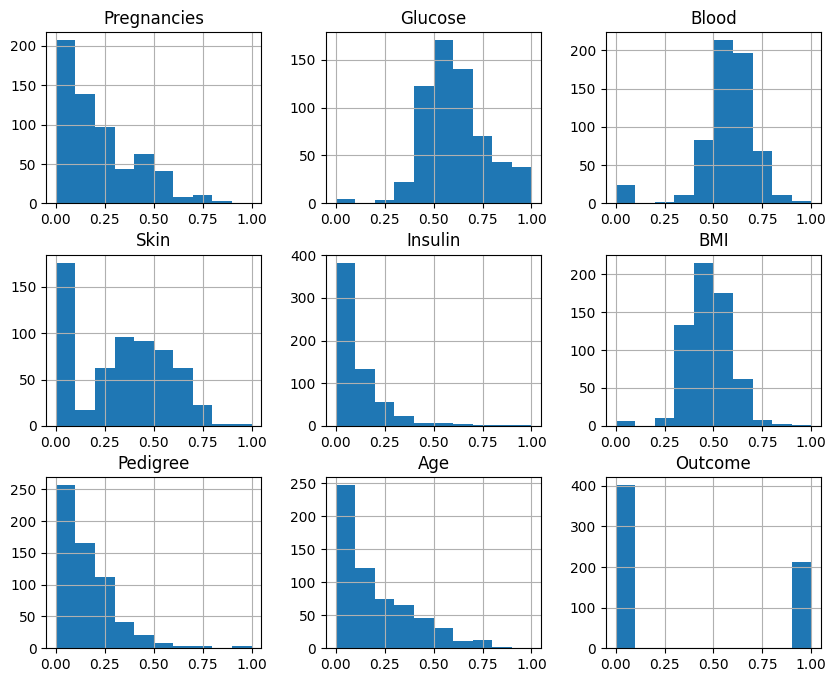

In [64]:
df_train.hist(figsize=(10,8))
plt.show()

### Boxplot Matrix

In [65]:
continuous_features = []
for feat in df_train.columns:
    if df_train[feat].nunique() > 2:
        continuous_features.append(feat)

num_cols = 3
num_rows = (len(continuous_features) + 1) // num_cols
fig = make_subplots(rows=num_rows, cols=num_cols)

for i, feature in enumerate(continuous_features):
    row = i // num_cols + 1
    col = i % num_cols + 1

    fig.add_trace(go.Box(x=df_train[feature], name = ' '), row=row, col=col)

    fig.update_yaxes(title_text = ' ', row=row, col=col)
    fig.update_xaxes(title_text= feature, row=row, col=col)
    fig.update_layout(
        title=f'<b>Boxplot Matrix<br> <sup> Continuous Features</sup></b>',
        showlegend=False, yaxis=dict(tickangle=-90)
    )

fig.update_layout(
    height=200 * num_rows,
    width=800,
    margin=dict(t=50, l=50),
    template= 'simple_white'
)
fig.show()

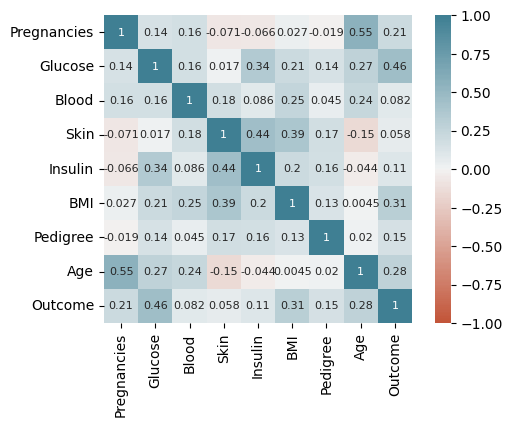

In [27]:
corr = df_train.corr()

plt.figure(figsize=(6, 4))
ax = sns.heatmap(
    corr,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square = True,
    annot = True,
    annot_kws = {'size': 8}
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='center'
)
plt.show()

### Distribuciones

<Figure size 1200x800 with 0 Axes>

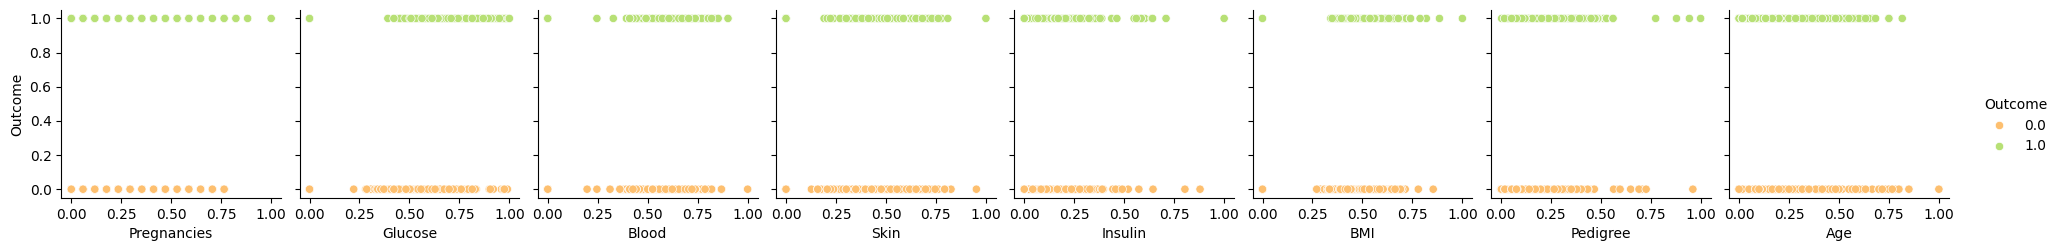

In [66]:
plt.figure(figsize=(12, 8))
sns.pairplot(df_train, hue='Outcome', x_vars=df_train.drop('Outcome', axis=1).columns, y_vars='Outcome', palette='RdYlGn')
plt.show()

# Red Neuronal / Clasificación

## Procesamiento en Test

### Pipeline de procesamiento

In [67]:
df_test

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
668,6,98,58,33,190,34.0,0.430,43,0
324,2,112,75,32,0,35.7,0.148,21,0
624,2,108,64,0,0,30.8,0.158,21,0
690,8,107,80,0,0,24.6,0.856,34,0
473,7,136,90,0,0,29.9,0.210,50,0
...,...,...,...,...,...,...,...,...,...
355,9,165,88,0,0,30.4,0.302,49,1
534,1,77,56,30,56,33.3,1.251,24,0
344,8,95,72,0,0,36.8,0.485,57,0
296,2,146,70,38,360,28.0,0.337,29,1


In [68]:
df_test = renombrar_columnas(df_test)
df_test = eliminar_registros_duplicados(df_test)
df_test = recategorizar_variables(df_test)
df_test, _ = escalar_datos(df_test, train_scaler_dict)

In [69]:
df_test

,Pregnancies,Glucose,Blood,Skin,Insulin,BMI,Pedigree,Age,Outcome
668,0.461538,0.266667,0.508772,0.333333,0.328152,0.639098,0.254658,0.478261,0.0
324,0.153846,0.370370,0.657895,0.323232,0.000000,0.671053,0.035714,0.000000,0.0
624,0.153846,0.340741,0.561404,0.000000,0.000000,0.578947,0.043478,0.000000,0.0
690,0.615385,0.333333,0.701754,0.000000,0.000000,0.462406,0.585404,0.282609,0.0
473,0.538462,0.548148,0.789474,0.000000,0.000000,0.562030,0.083851,0.630435,0.0
...,...,...,...,...,...,...,...,...,...
355,0.692308,0.762963,0.771930,0.000000,0.000000,0.571429,0.155280,0.608696,1.0
534,0.076923,0.111111,0.491228,0.303030,0.096718,0.625940,0.892081,0.065217,0.0
344,0.615385,0.244444,0.631579,0.000000,0.000000,0.691729,0.297360,0.782609,0.0
296,0.153846,0.622222,0.614035,0.383838,0.621762,0.526316,0.182453,0.173913,1.0


### Conjuntos X e y

In [70]:
X_test, y_test = separar_Xy(df_test, 'Outcome')

In [71]:
X_test.shape, y_test.shape

((154, 8), (154, 1))

## Modelo

### Definición y entrenamiento

In [96]:
# Definición del Modelo
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(16, activation='relu'), Dropout(0.1),
    Dense(12, activation='relu'), Dropout(0.1),
    Dense(1, activation='sigmoid')
])

In [97]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 16)                144       
                                                                 
 dropout_8 (Dropout)         (None, 16)                0         
                                                                 
 dense_13 (Dense)            (None, 12)                204       
                                                                 
 dropout_9 (Dropout)         (None, 12)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 13        
                                                                 
Total params: 361 (1.41 KB)
Trainable params: 361 (1.41 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [102]:
# Entrenamiento
print("Inicio del Entrenamiento")
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2, verbose=1)

Inicio del Entrenamiento
Epoch 1/500
16/16 [==============================] - 3s 47ms/step - loss: 0.4676 - accuracy: 0.7760 - val_loss: 0.4888 - val_accuracy: 0.7642
Epoch 2/500
16/16 [==============================] - 0s 11ms/step - loss: 0.4667 - accuracy: 0.7821 - val_loss: 0.4933 - val_accuracy: 0.7805
Epoch 3/500
16/16 [==============================] - 0s 15ms/step - loss: 0.4474 - accuracy: 0.7923 - val_loss: 0.4891 - val_accuracy: 0.7724
Epoch 4/500
16/16 [==============================] - 0s 14ms/step - loss: 0.4527 - accuracy: 0.7862 - val_loss: 0.4893 - val_accuracy: 0.7886
Epoch 5/500
16/16 [==============================] - 0s 13ms/step - loss: 0.4556 - accuracy: 0.7800 - val_loss: 0.4881 - val_accuracy: 0.7805
Epoch 6/500
16/16 [==============================] - 0s 11ms/step - loss: 0.4507 - accuracy: 0.7923 - val_loss: 0.4886 - val_accuracy: 0.7886
Epoch 7/500
16/16 [==============================] - 0s 10ms/step - loss: 0.4499 - accuracy: 0.7902 - val_loss: 0.4879 - va

### Visualización de Métricas

In [103]:
# Evaluación del modelo en el conjunto de prueba
predictions_prob = model.predict(X_test)
# Aplicar umbral para obtener etiquetas binarias
threshold = 0.5  # Ajusta el umbral según sea necesario
predictions = (predictions_prob > threshold).astype(int)

5/5 [==============================] - 0s 2ms/step


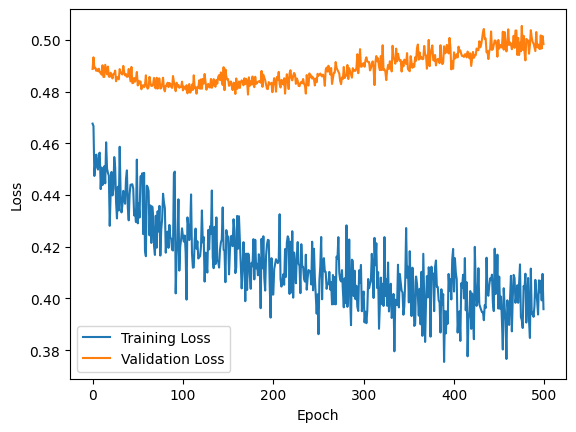

In [104]:
# Gráfico
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [105]:
print("--------------------------")
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1_score = 2 * (precision * recall) / (precision + recall)
conf_matrix = confusion_matrix(y_test, predictions)
classification_rep = classification_report(y_test, predictions)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("F1-Score: {:.2f}%".format(f1_score * 100))
print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

--------------------------
Accuracy: 74.03%
Precision: 65.96%
Recall: 56.36%
F1-Score: 60.78%

Confusion Matrix:
 [[83 16]
 [24 31]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.84      0.81        99
         1.0       0.66      0.56      0.61        55

    accuracy                           0.74       154
   macro avg       0.72      0.70      0.71       154
weighted avg       0.73      0.74      0.74       154



### Predicciones

In [ ]:
# Crear DataFrame con datos originales
predicciones = pd.DataFrame(df_test, columns=df_test.columns)

# Obtener los scalers para revertir la normalización
for columna in df_test.columns:
    if columna != 'Index' and columna != 'Predicted Index':
        predicciones[columna] = train_scaler_dict[columna].inverse_transform(predicciones[columna].values.reshape(-1, 1))

# Aplicar la transformación inversa solo a las columnas 'Index' y 'Predicted Index'
predicciones['Index'] = y_test
predicciones['Predicted Index'] = y_pred
predicciones[['Index', 'Predicted Index']] = train_scaler_dict['Index'].inverse_transform(predicciones[['Index', 'Predicted Index']])
predicciones['Predicted Index'] = predicciones['Predicted Index'].round(3)  # Redondear a 3 decimales


# Mostrar la tabla de predicciones
predicciones

,Hs_Studied,Prev_Score,Extra_Act,Sleep_Hs,Practiced,Index,Predicted Index
6252,5.0,69.0,0.0,8.0,2.0,51.0,54.300
4684,2.0,46.0,1.0,4.0,8.0,20.0,29.590
1731,7.0,56.0,1.0,7.0,5.0,46.0,49.775
4742,6.0,42.0,1.0,8.0,5.0,28.0,36.428
4521,7.0,53.0,0.0,4.0,6.0,41.0,45.622
...,...,...,...,...,...,...,...
6412,2.0,70.0,0.0,7.0,3.0,45.0,48.913
8285,4.0,79.0,0.0,9.0,3.0,66.0,61.589
7853,2.0,40.0,1.0,7.0,2.0,16.0,24.888
1095,3.0,83.0,0.0,7.0,5.0,65.0,61.824


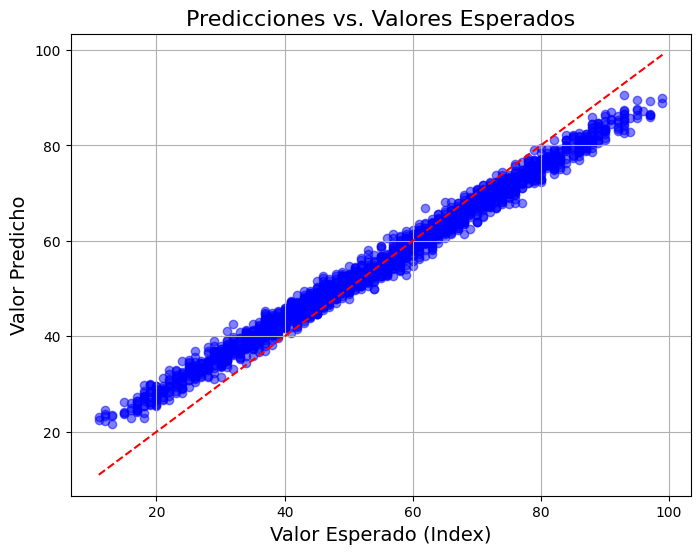

In [ ]:
# Crear el gráfico de dispersión
plt.figure(figsize=(8, 6))
plt.scatter(predicciones['Index'], predicciones['Predicted Index'], color='blue', alpha=0.5)  # Scatter plot de los valores esperados vs. predichos
plt.plot([predicciones['Index'].min(), predicciones['Index'].max()], [predicciones['Index'].min(), predicciones['Index'].max()], color='red', linestyle='--')  # Línea diagonal para referencia
plt.title('Predicciones vs. Valores Esperados', fontsize=16)
plt.xlabel('Valor Esperado (Index)', fontsize=14)
plt.ylabel('Valor Predicho', fontsize=14)
plt.grid(True)
plt.show()